## Load imports and datasets

In [114]:
# Runs all imports
import pandas as pd
import datetime
from datetime import timedelta
import numpy as np

# Displays all datasets' columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

In [115]:
if True:
    # Log into Darwin SDK
    from amb_sdk.sdk import DarwinSdk
    s = DarwinSdk()
    s.set_url('https://amb-demo-api.sparkcognition.com/v1/')
    s.auth_login_user('ethan.freeburg@utexas.edu','AAn7WQfgqk')

## Load Main Dataset

In [116]:
# Creates a table from compressed csvs in a directory
import os

DIR = 'data_details'

os.chdir(DIR)

tables = []
for file in os.listdir():
    tables.append(pd.read_csv(file, compression='gzip'))

os.chdir('../')

raw = pd.concat(tables)
    
raw.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,200802,22,1300,200802,22,2200,14216,79884,NEW HAMPSHIRE,33,2008,February,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,22-FEB-08 13:00:00,EST-5,22-FEB-08 22:00:00,0,0,0,0,0.00K,0.00K,Public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A noreaster moved up the coast southeast of Ca...,NaN,CSV
1,200804,1,352,200804,1,352,15549,88334,NEW HAMPSHIRE,33,2008,April,High Wind,Z,12,EASTERN HILLSBOROUGH,BOX,01-APR-08 03:52:00,EST-5,01-APR-08 03:52:00,0,0,0,0,0.00K,0.00K,Amateur Radio,52.0,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strong southwest flow behind a warm front allo...,An amateur radio operator recorded a wind gust...,CSV
2,200803,1,0,200803,1,1320,14773,83820,NEW HAMPSHIRE,33,2008,March,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,01-MAR-08 00:00:00,EST-5,01-MAR-08 13:20:00,0,0,0,0,0.00K,0.00K,Trained Spotter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure tracked from the Great Lakes acro...,NaN,CSV
3,200801,14,500,200801,14,1700,13559,75727,NEW HAMPSHIRE,33,2008,January,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,14-JAN-08 05:00:00,EST-5,14-JAN-08 17:00:00,0,0,0,0,10.00K,0.00K,Trained Spotter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure moved up the Atlantic coast and s...,NaN,CSV
4,200812,19,1353,200812,21,200,25148,146588,NEW HAMPSHIRE,33,2008,December,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,19-DEC-08 13:53:00,EST-5,21-DEC-08 02:00:00,0,0,0,0,0.00K,0.00K,Trained Spotter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An intensifying coastal low spread heavy snow ...,Six to eight inches of snow fell across easter...,CSV


## Reformat Data

In [119]:
data = raw.copy()

# --------------------- CLEANING ---------------------
# split and BEGIN_YEARMONTH + END_YEARMONTH columns into 2 columns each --> YEAR + MONTH
begin_year = data['BEGIN_YEARMONTH'].astype(str).str[:4]
begin_month = data['BEGIN_YEARMONTH'].astype(str).str[4:]
data['BEGIN_YEAR'] = begin_year
data['BEGIN_MONTH'] = begin_month
#data.drop(columns=['BEGIN_YEARMONTH'], inplace=True)

end_year = data['END_YEARMONTH'].astype(str).str[:4]
end_month = data['END_YEARMONTH'].astype(str).str[4:]
data['END_YEAR'] = end_year
data['END_MONTH'] = end_month
#data.drop(columns=['END_YEARMONTH'], inplace=True)

# add begin and end dates and times in YYYY-MM-DD HH:MM:SS format
begin = data['BEGIN_YEAR'].map(str) + '-' + data['BEGIN_MONTH'].map(str) + '-' + data['BEGIN_DAY'].map(str) + ' '
hour = data['BEGIN_TIME'].astype(str).str[:-2]
hour = hour.apply(lambda x: '{0:0>2}'.format(x))
minute = data['BEGIN_TIME'].astype(str).str[-2:]
minute = minute.apply(lambda x: '{0:0>2}'.format(x))
time = hour.map(str) + ':' + minute.map(str) + ':00'
data['BEGIN'] = begin+time

end = data['END_YEAR'].map(str) + '-' + data['END_MONTH'].map(str) + '-' + data['END_DAY'].map(str) + ' '
e_hour = data['END_TIME'].astype(str).str[:-2]
e_hour = e_hour.apply(lambda x: '{0:0>2}'.format(x))
e_minute = data['END_TIME'].astype(str).str[-2:]
e_minute = e_minute.apply(lambda x: '{0:0>2}'.format(x))
e_time = e_hour.map(str) + ':' + e_minute.map(str) + ':00'
data['END'] = end+e_time

# add duration column
duration = pd.to_datetime(data_mapped['END']) - pd.to_datetime(data_mapped['BEGIN'])
data['DURATION_seconds'] = ((duration.dt.total_seconds())) 

#change DAMAGE_PROPERTY and DAMAGE_CROPS type from #.##K to float
def convertToFloat(x):
    x = str(x)
    if(x[-1]=='K'):
        return(float(x[0:-1])*1000)
    elif(x[-1]=='M'):
        return(float(x[0:-1])*1000000)
    elif(x[-1]=='B'):
        return(float(x[0:-1])*1000000000)
    else:
        return(0.0)

    
#print(pd.value_counts(data.DAMAGE_PROPERTY))
#print(pd.value_counts(data.DAMAGE_CROPS))
data['DAMAGE_PROPERTY'].fillna(0.0, inplace=True)
data['DAMAGE_PROPERTY'] = data['DAMAGE_PROPERTY'].apply(convertToFloat)

data['DAMAGE_CROPS'].fillna(0.0, inplace=True)
data['DAMAGE_CROPS'] = data['DAMAGE_CROPS'].apply(convertToFloat)

# Explore Data Components

In [26]:
desc = data.describe(include='all')
desc

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,BEGIN_YEAR,BEGIN_MONTH,END_YEAR,END_MONTH,BEGIN,END
count,683982.000000,683982.000000,683982.000000,683982.000000,683982.000000,683982.000000,683982.000000,683982.000000,683982,683982.000000,683982.000000,683982,683982,683982,683982.000000,683982,683982,683982,683982,683982,683982.000000,683982.000000,683982.000000,683982.000000,568908,565471,683982,365516.000000,235847,69724,277.000000,15134,15134.000000,15134.000000,1903,1903,1903.0000,1903,433481.000000,433481,433481,433481.000000,433481,433481,433481.000000,433481.000000,433481.000000,433481.000000,683982,492890,683982,683982,683982,683982,683982,683982,683982
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,NaN,NaN,12,56,3,NaN,4181,123,354343,9,347741,NaN,NaN,NaN,NaN,1502,455,44,NaN,4,7,NaN,7,NaN,NaN,85,39,NaN,731,NaN,16,42528,NaN,16,42878,NaN,NaN,NaN,NaN,102145,428398,1,11,12,11,12,354343,347741
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEXAS,NaN,NaN,June,Thunderstorm Wind,C,NaN,WASHINGTON,LWX,01-JUL-12 00:00:00,CST-6,31-JUL-12 23:59:00,NaN,NaN,NaN,NaN,0.00K,0.00K,Trained Spotter,NaN,EG,Heavy Rain,NaN,EF0,NaN,NaN,JAN,AL,NaN,MADISON,NaN,N,SPRINGFIELD,NaN,N,SPRINGFIELD,NaN,NaN,NaN,NaN,A strong upper-level disturbance passed throug...,Wind gusts were estimated at 60 mph.,CSV,2011,06,2011,06,2012-07-1 00:00:00,2012-07-31 23:59:00
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47599,NaN,NaN,104721,172886,412313,NaN,5422,23416,1163,324875,1107,NaN,NaN,NaN,NaN,404084,551922,125634,NaN,171868,62904,NaN,7901,NaN,NaN,140,192,NaN,22,NaN,104554,483,NaN,96475,465,NaN,NaN,NaN,NaN,294,684,683982,79091,104721,79091,104721,1163,1107
mean,201286.661820,14.923438,1276.620968,201286.661822,16.625633,1465.462794,72095.015774,432003.999851,NaN,32.312742,2012.807284,NaN,NaN,NaN,98.374020,NaN,NaN,NaN,NaN,NaN,0.043320,0.016777,0.008594,0.003300,NaN,NaN,NaN,33.951083,NaN,NaN,1.490975,NaN,3.067298,182.755379,NaN,NaN,103.7299,NaN,2.410599,NaN,NaN,2.444181,NaN,NaN,37.838124,-90.261514,37.835244,-90.254036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,315.112678,9.215241,680.820287,315.112676,9.207156,612.990317,34440.257262,208244.474812,NaN,18.154240,3.151748,NaN,NaN,NaN,122.789436,NaN,NaN,NaN,NaN,NaN,2.577603,3.045148,0.277897,0.135616,NaN,NaN,NaN,25.179454,NaN,NaN,1.048165,NaN,4.246596,287.020573,NaN,NaN,83.1857,NaN,4.446881,NaN,NaN,4.471382,NaN,NaN,5.022057,11.126900,5.022675,11.124569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,200801.000000,1.000000,0.000000,200801.000000,1.000000,0.000000,11748.000000,64592.000000,NaN,1.000000,2008.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,0.010000,1.000000,NaN,NaN,1.0000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,-14.400000,-170.919800,-14.456000,-170.868900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,201007.000000,7.000000,753.000000,201007.000000,9.000000,1100.000000,42904.000000,251659.250000,NaN,19.000000,2010.000000,NaN,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.250000,NaN,NaN,1.000000,NaN,0.430000,50.000000,NaN,NaN,47.0000,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,34.602600,-97.140000,34.600000,-97.137700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,201302.000000,15.000000,1452.000000,201302.000000,17.000000,1600.000000,71618.000000,432052.500000,NaN,31.000000,2013.000000,NaN,NaN,NaN,63.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,50.000000,NaN,NaN,

Upstream analysis suggets that several fields do not have sufficient information to perform data analysis upon. The following code block determines which do not meet a predefined threshold of missing values before recommending dropping.

In [27]:
row_count = len(data.index)

threshold = 0.5

analysis = pd.DataFrame(columns=['Field','Missing','Reccomendation'])

for a in desc.columns.values:
    missing = 1 - desc[a]['count'] / row_count
    rec = 'Keep'
    if missing > threshold:
        rec = 'Drop'
    
    analysis = analysis.append({'Field': a,'Missing': missing,'Reccomendation':rec},ignore_index=True)
    
            
analysis

,Field,Missing,Reccomendation
0,BEGIN_YEARMONTH,0.000000,Keep
1,BEGIN_DAY,0.000000,Keep
2,BEGIN_TIME,0.000000,Keep
3,END_YEARMONTH,0.000000,Keep
4,END_DAY,0.000000,Keep
5,END_TIME,0.000000,Keep
6,EPISODE_ID,0.000000,Keep
7,EVENT_ID,0.000000,Keep
8,STATE,0.000000,Keep
9,STATE_FIPS,0.000000,Keep


## Narrow and Flatten Data

In [169]:
#drops
drop_list = ["BEGIN_YEARMONTH",
             "END_YEARMONTH",
             "EPISODE_ID",
             "EVENT_ID",
             "STATE_FIPS",
             "BEGIN_DAY",
             "BEGIN_TIME",
             "END_DAY",
             "END_TIME",
             "CATEGORY",
             "CZ_TYPE",
             "CZ_FIPS",             
             "CZ_NAME",
             "TOR_OTHER_WFO",
             "TOR_OTHER_CZ_NAME",
             "TOR_OTHER_CZ_STATE",
             "TOR_OTHER_CZ_FIPS",
             "WFO",
             "END_DATE_TIME",
             "CZ_TIMEZONE",
             "BEGIN_RANGE",
             "BEGIN_AZIMUTH",
             "BEGIN_YEAR",            
             "BEGIN_MONTH",
             "END_YEAR",
             "END_MONTH",
             "BEGIN",
             "END"            
            ]

data_narrow = data.drop(drop_list, axis = 1)


#remove the row if no location information is provided
#note this removes 250501 rows, reducing our dataset by 37%
data_flat = data_narrow.copy()

#print(data_flat.head())

#print(pd.notnull(data['BEGIN_LOCATION']).head())

#data_flat = data_flat[pd.notnull(data_flat['BEGIN_LOCATION'])]
#data_flat = data_flat[pd.notnull(data_flat['END_LOCATION'])]



## Read in More Data

In [170]:
cat_map = pd.read_csv('data_other/analyst_defined_weather_category_map.csv')
cat_map.head(20)

,Weather Category,Event Type
0,Wind,Thunderstorm Wind
1,Wind,High Wind
2,Wind,Marine Thunderstorm Wind
3,Wind,Marine High Wind
4,Wind,Strong Wind
5,Wind,Marine Strong Wind
6,Winter Weather,Winter Weather
7,Winter Weather,Winter Storm
8,Winter Weather,Heavy Snow
9,Winter Weather,Blizzard


In [171]:
# Merge data together
data_mapped = data_flat.merge(cat_map,how="left",left_on='EVENT_TYPE',right_on='Event Type')

In [173]:
data_flat['EVENT_TYPE'].unique()
#data_mapped['Weather Category'].unique()

array(['Heavy Snow', 'High Wind', 'Ice Storm', 'Hail',
       'Thunderstorm Wind', 'Flood', 'Marine Thunderstorm Wind',
       'Cold/Wind Chill', 'Dense Fog', 'Winter Weather', 'Winter Storm',
       'Lake-Effect Snow', 'Blizzard', 'Flash Flood', 'Tornado',
       'Extreme Cold/Wind Chill', 'Seiche', 'Heavy Rain', 'Strong Wind',
       'Lightning', 'Drought', 'Avalanche', 'High Surf', 'Waterspout',
       'Funnel Cloud', 'Astronomical Low Tide', 'Frost/Freeze',
       'Freezing Fog', 'Rip Current', 'Storm Surge/Tide', 'Wildfire',
       'Tropical Storm', 'Marine Hail', 'Sleet', 'Coastal Flood',
       'Dust Devil', 'Heat', 'Dense Smoke', 'Dust Storm',
       'Marine High Wind', 'Volcanic Ashfall', 'Excessive Heat',
       'Landslide', 'Marine Strong Wind', 'Tropical Depression',
       'Hurricane (Typhoon)', 'Tsunami', 'Lakeshore Flood', 'Hurricane',
       'Sneakerwave', 'Debris Flow', 'Marine Tropical Storm',
       'Marine Dense Fog', 'Marine Hurricane/Typhoon', 'Marine Lightning',


## Analyize property Damage properties

100000000.0


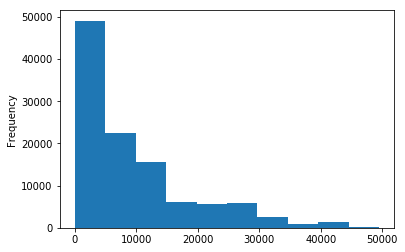

In [48]:
print(0.01*data['DAMAGE_PROPERTY'].max())
data_cut = data.loc[(data['DAMAGE_PROPERTY'] > 1) & (data['DAMAGE_PROPERTY'] < 50000)]
#data_cut = data.loc[(data['DAMAGE_PROPERTY'] > 1) & (data['DAMAGE_PROPERTY'] < 25000)]
data_cut['DAMAGE_PROPERTY'].plot.hist()
#data_mapped.groupby('Weather Category').count()['Event Type']

In [174]:
# --------------------- FEATURE ENGINEERING ---------------------  

#separates hail size / wind speed MAGNITUDE
data_mapped['WIND_SPEED'] = np.where(data_mapped['MAGNITUDE_TYPE'].isin(['MG','EG']), data_mapped['MAGNITUDE'], np.NaN)
data_mapped['HAIL_SIZE'] = np.where(data_mapped['MAGNITUDE_TYPE'].isna(), data_mapped['MAGNITUDE'], np.NaN)

#divide the data into 12 distinct groups by event type:
#pd.value_counts(data.EVENT_TYPE)
"""
Wind (COLE):
Winter Weather (ETHAN):
Rain (FREYA):
Hail (RUOCHEN):
Flood (FREYA):
Drought (ETHAN):
Tornado (COLE):
Heat (ETHAN):
Cold (COLE):
Lightning (FREYA):
Wildfire (RUOCHEN)
Tides/Currents (RUOCHEN)
"""

#data.columns
#data.head(50)

'\nWind (COLE):\nWinter Weather (ETHAN):\nRain (FREYA):\nHail (RUOCHEN):\nFlood (FREYA):\nDrought (ETHAN):\nTornado (COLE):\nHeat (ETHAN):\nCold (COLE):\nLightning (FREYA):\nWildfire (RUOCHEN)\nTides/Currents (RUOCHEN)\n'

In [175]:
data_mapped.head()

,STATE,YEAR,MONTH_NAME,EVENT_TYPE,BEGIN_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,DURATION_seconds,Weather Category,Event Type,WIND_SPEED,HAIL_SIZE
0,NEW HAMPSHIRE,2008,February,Heavy Snow,22-FEB-08 13:00:00,0,0,0,0,0.0,0.0,Public,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A noreaster moved up the coast southeast of Ca...,NaN,CSV,0.0,Winter Weather,Heavy Snow,NaN,NaN
1,NEW HAMPSHIRE,2008,April,High Wind,01-APR-08 03:52:00,0,0,0,0,0.0,0.0,Amateur Radio,52.0,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strong southwest flow behind a warm front allo...,An amateur radio operator recorded a wind gust...,CSV,0.0,Wind,High Wind,52.0,NaN
2,NEW HAMPSHIRE,2008,March,Heavy Snow,01-MAR-08 00:00:00,0,0,0,0,0.0,0.0,Trained Spotter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure tracked from the Great Lakes acro...,NaN,CSV,7200.0,Winter Weather,Heavy Snow,NaN,NaN
3,NEW HAMPSHIRE,2008,January,Heavy Snow,14-JAN-08 05:00:00,0,0,0,0,10000.0,0.0,Trained Spotter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low pressure moved up the Atlantic coast and s...,NaN,CSV,0.0,Winter Weather,Heavy Snow,NaN,NaN
4,NEW HAMPSHIRE,2008,December,Heavy Snow,19-DEC-08 13:53:00,0,0,0,0,0.0,0.0,Trained Spotter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An intensifying coastal low spread heavy snow ...,Six to eight inches of snow fell across easter...,CSV,0.0,Winter Weather,Heavy Snow,NaN,NaN


In [200]:
# WIND MODEL
event_title = 'winter'

model_data = data_mapped.loc[(data_mapped['Weather Category'] == 'Winter Weather')]

# Drop data that we don't want included in the model
model_data = model_data.drop(["INJURIES_DIRECT", 
                            'INJURIES_INDIRECT', 
                            'DEATHS_DIRECT', 
                            'DEATHS_INDIRECT', 
                            'DAMAGE_CROPS'], axis = 1)

# Drap data irrevelent to the Wind Model
model_data = model_data.drop(["Event Type",
                            "Weather Category",
                            "FLOOD_CAUSE", 
                            'TOR_F_SCALE', 
                            'TOR_LENGTH', 
                            'TOR_WIDTH',
                            'HAIL_SIZE'], axis = 1)

# Take out a 500 row subset of test data

data_test = model_data.sample( min(1000, 0.01*len(model_data.index)) )
data_train = model_data.drop(data_test.index)

# convert the test data and the main data to a csv
print('Creating CSVs')
data_test.to_csv('temp/'+event_title+'_data_test.csv')
data_train.to_csv('temp/'+event_title+'_data_train.csv')

Creating CSVs


In [202]:
#s.lookup_dataset()
s.delete_dataset('winter_data_train')
s.delete_dataset('winterdata_test')

(True, None)

In [203]:
# Upload the train to Darwin
#print('Deleting existing datasets')
print('Uploading to Darwin')
s.upload_dataset('temp/'+event_title+'_data_train.csv', event_title + '_data_train')
s.upload_dataset('temp/'+event_title+'_data_test.csv',  event_title + '_data_test')

# Clean the training dataset using Darwin
print('starting Clean')
out = s.clean_data(event_title + '_data_train',target = 'DAMAGE_PROPERTY')
print(out)

Uploading to Darwin
starting Clean
(True, {'job_name': '123c9517dbda461cb561f06f4373dff9', 'artifact_name': '3df13b2d32dc43c4ad5f6d7298158ad0'})


In [204]:
# Cleaning the data
print('Waiting on Cleaning')
cleaning_job_name = out[1]['job_name']
s.wait_for_job(cleaning_job_name) # prints out error report

Waiting on Cleaning
{'status': 'Requested', 'starttime': '2019-04-20T18:20:14.745764', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['winter_data_train'], 'artifact_names': ['3df13b2d32dc43c4ad5f6d7298158ad0'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T18:20:14.745764', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['winter_data_train'], 'artifact_names': ['3df13b2d32dc43c4ad5f6d7298158ad0'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T18:20:14.745764', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['winter_data_train'], 'artifact_names': ['3df13b2d32dc43c4ad5f6d7298158ad0'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T18:20:14.745764', 'endt

(True, 'Job completed')

In [205]:
s.lookup_dataset_name('winter_data_train')
#s.download_dataset('wind_data_test')

(True,
 {'mbytes': 116.42669486999512,
  'minimum_recommeded_train_time': '10 minutes',
  'updated_at': '2019-04-20T18:20:11.326135',
  'categorical': None,
  'sequential': None,
  'imbalanced': None})

In [206]:
# Create the model
print('Creating Model')
print(s.delete_model('winter_model'))
out = s.create_model(dataset_names='winter_data_train', model_name='winter_model', max_train_time = '00:05')
print(out)

Creating Model
(True, None)
(True, {'job_name': '38c70369d56f413e9be4e13e71d63aae', 'job_id': '0a076b76-63c3-11e9-9ba2-17d9eb9858f4', 'model_name': 'winter_model'})


In [207]:
# Wiat for the model to complete
print('Waiting on Construction')
construct_job_name = out[1]['job_name']
s.wait_for_job(construct_job_name)

(True, {'job_name': '38c70369d56f413e9be4e13e71d63aae', 'job_id': '0a076b76-63c3-11e9-9ba2-17d9eb9858f4', 'model_name': 'winter_model'})
Waiting on Construction
{'status': 'Running', 'starttime': '2019-04-20T18:21:34.953405', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['winter_data_train'], 'artifact_names': None, 'model_name': 'winter_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T18:21:34.953405', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['winter_data_train'], 'artifact_names': None, 'model_name': 'winter_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T18:21:34.953405', 'endtime': None, 'percent_complete': 7, 'job_type': 'TrainModel', 'loss': None, 'generations': 1, 'dataset_names': ['winter_data_train'], 'artifact_names': None, 'model_name': 'winter_model', 'job_error': ''}
{'status': 'Runni

(True, 'Job completed')

In [208]:
out = s.clean_data('winter_data_test', model_name='winter_model')
print(out)

(True,
 {'job_name': 'ffd061c766314fd0918fe09c3737e528',
  'artifact_name': '2856e19fc08f49b486767502a3c5d452'})

In [209]:
jn = out[1]['job_name']
s.wait_for_job(jn)

{'status': 'Running', 'starttime': '2019-04-20T18:29:17.457238', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['winter_data_test'], 'artifact_names': ['2856e19fc08f49b486767502a3c5d452'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T18:29:17.457238', 'endtime': '2019-04-20T18:29:24.565407', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['winter_data_test'], 'artifact_names': ['2856e19fc08f49b486767502a3c5d452'], 'model_name': None, 'job_error': ''}


(True, 'Job completed')

In [210]:
out = s.run_model('winter_data_test', 'winter_model')

(True,
 {'job_name': 'c6e4a28ab33c4db7a44ef72afd4fbf1f',
  'artifact_name': '4a98b4f467884dd8b8610ced4c1e844b'})

In [211]:
jn = out[1]['job_name']
s.wait_for_job(jn)

{'status': 'Complete', 'starttime': '2019-04-20T18:31:33.599564', 'endtime': '2019-04-20T18:31:35.749551', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': None, 'generations': 2, 'dataset_names': ['winter_data_test'], 'artifact_names': ['4a98b4f467884dd8b8610ced4c1e844b'], 'model_name': 'winter_model', 'job_error': ''}


(True, 'Job completed')

In [212]:
 
artifact = s.download_artifact('4a98b4f467884dd8b8610ced4c1e844b')

In [214]:
pred = artifact[1]['DAMAGE_PROPERTY']
y_col = wind_data_test['DAMAGE_PROPERTY']

#print(pred)

xs = []
ys = []
for i in range(500):
    xs.append(y_col.iloc[i])
    ys.append(pred.iloc[i])

accuracy = pd.DataFrame({'Actual':xs,'Predicted':ys})

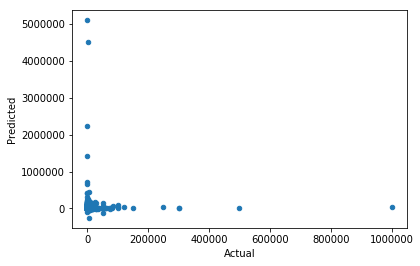

In [215]:
accuracy.plot.scatter('Actual','Predicted')